In [32]:
import matplotlib

import numpy as np
import tensorflow as tf
from keras import backend as K
from keras import utils as keras_utils
from keras import optimizers
from keras import datasets
from keras.datasets import mnist

from tqdm import tqdm

In [33]:
NOISE_DIM = 100
CAT_DIM   = 10
IMG_LEN_TO_SAVE = 10  # число картинок для сохранения, всего будет 10*IMG_LEN_TO_SAVE картинок 

In [34]:
import math
import os
import subprocess
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np


def combine_images(generated_images): # формирует сетку из картинок
    num_images = generated_images.shape[0]
    new_width = int(math.sqrt(num_images))
    new_height = int(math.ceil(float(num_images) / new_width))
    grid_shape = generated_images.shape[1:3]
    grid_image = np.zeros((new_height * grid_shape[0], new_width * grid_shape[1]), dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index / new_width)
        j = index % new_width
        grid_image[i * grid_shape[0]:(i + 1) * grid_shape[0], j * grid_shape[1]:(j + 1) * grid_shape[1]] = \
            img[:, :, 0]
    return grid_image


def generate_noise(shape: tuple):   # генерируем матрицу шума
    noise = np.random.uniform(0, 1, size=shape) # случайное число с плавающей запятой в данном диапазоне
    return noise


def generate_condition_embedding(label: int, nb_of_label_embeddings: int):  # генерируем тип для картинок [0 1 0 0 ...]
    label_embeddings = np.zeros((nb_of_label_embeddings, CAT_DIM))
    label_embeddings[:, label] = 1
    return label_embeddings


def generate_images(generator, nb_images: int, label: int): # генерируем картинки из вектора шума и заданных меток
    noise = generate_noise((nb_images, NOISE_DIM))
    label_batch = generate_condition_embedding(label, nb_images)   # матрица меток
    generated_images = generator.predict([noise, label_batch], verbose=0)
    return generated_images


def generate_mnist_image_grid(generator, title: str = "Generated images"):  # сохраняем картинки на шагах эпохи
    generated_images = []

    for i in range(10):   # здесь 10 - число категорий !!!
        noise = generate_noise((IMG_LEN_TO_SAVE, NOISE_DIM))
        label_input = generate_condition_embedding(i, IMG_LEN_TO_SAVE)   
        gen_images = generator.predict([noise, label_input], verbose=0)
        generated_images.extend(gen_images)

    generated_images = np.array(generated_images)
    image_grid = combine_images(generated_images)
    image_grid = inverse_transform_images(image_grid)

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.axis("off")
    ax.imshow(image_grid, cmap="gray")
    ax.set_title(title)
    fig.canvas.draw()

    image = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')   
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    plt.close()

    return image


def save_generated_image(image, epoch, iteration, folder_path):  # сохраняем сгенерированные катринки
    if not os.path.isdir(folder_path): # создаем недостоющие каталоги
        os.makedirs(folder_path)

    file_path = "{0}/{1}_{2}.png".format(folder_path, epoch, iteration)
    img = tf.keras.preprocessing.image.array_to_img(image.astype(np.uint8))
    img.save(file_path)


def transform_images(images: np.ndarray):  # перевод в диапазон [-1,1]
    images = (images.astype(np.float32) - 127.5) / 127.5
    return images


def inverse_transform_images(images: np.ndarray): # перевод в диапазон [0,255]
    images = images * 127.5 + 127.5
    images = images.astype(np.uint8)
    return images



In [35]:
BATCH_SIZE = 128

Работа с данными MNIST

In [36]:
(X_train, y_train), (_, _) = mnist.load_data()  # загружаем данные
X_train = transform_images(X_train)
print(X_train.shape)
X_train = X_train[:, :, :, None]
print(X_train.shape, y_train.shape )

(60000, 28, 28)
(60000, 28, 28, 1) (60000,)


In [37]:
y_train = tf.keras.utils.to_categorical(y_train, CAT_DIM) # создали матрицу [0 1 0 ...]


In [38]:
print(X_train.shape,y_train.shape)
print(y_train[0])

(60000, 28, 28, 1) (60000, 10)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


Создаем модели сети

In [39]:

from keras import models, layers

ACTIVATION = layers.Activation("tanh")


def generator_model():
    # обрабатываем шум
    input_z = layers.Input((NOISE_DIM,))
    dense_z_1 = layers.Dense(1024)(input_z)
    act_z_1 = ACTIVATION(dense_z_1)
    dense_z_2 = layers.Dense(128 * 7 * 7)(act_z_1)
    bn_z_1 = layers.BatchNormalization()(dense_z_2)
    reshape_z = layers.Reshape((7, 7, 128), input_shape=(128 * 7 * 7,))(bn_z_1)

    # обрабатываем входные метки
    input_c = layers.Input((CAT_DIM,))
    dense_c_1 = layers.Dense(1024)(input_c)
    act_c_1 = ACTIVATION(dense_c_1)
    dense_c_2 = layers.Dense(128 * 7 * 7)(act_c_1)
    bn_c_1 = layers.BatchNormalization()(dense_c_2)
    reshape_c = layers.Reshape((7, 7, 128), input_shape=(128 * 7 * 7,))(bn_c_1)

    # совмещаем выходы блоков
    concat_z_c = layers.Concatenate()([reshape_z, reshape_c])

    # обрабатываем совместно и получаем картинку
    up_1 = layers.UpSampling2D(size=(2, 2))(concat_z_c)
    conv_1 = layers.Conv2D(64, (5, 5), padding='same')(up_1)
    act_1 = ACTIVATION(conv_1)
    up_2 = layers.UpSampling2D(size=(2, 2))(act_1)
    conv_2 = layers.Conv2D(1, (5, 5), padding='same')(up_2)
    act_2 = layers.Activation("tanh")(conv_2)
    model = models.Model(inputs=[input_z, input_c], outputs=act_2)
    
    return model


def discriminator_model():
    
    # обработка картинки
    input_gen_image = layers.Input((28, 28, 1))
    conv_1_image = layers.Conv2D(64, (5, 5), padding='same')(input_gen_image)
    act_1_image = ACTIVATION(conv_1_image)
    pool_1_image = layers.MaxPooling2D(pool_size=(2, 2))(act_1_image)
    conv_2_image = layers.Conv2D(128, (5, 5))(pool_1_image)
    act_2_image = ACTIVATION(conv_2_image)
    pool_2_image = layers.MaxPooling2D(pool_size=(2, 2))(act_2_image)

    # обработка меток
    input_c = layers.Input((CAT_DIM,))
    dense_1_c = layers.Dense(1024)(input_c)
    act_1_c = ACTIVATION(dense_1_c)
    dense_2_c = layers.Dense(5 * 5 * 128)(act_1_c)
    bn_c = layers.BatchNormalization()(dense_2_c)
    reshaped_c = layers.Reshape((5, 5, 128))(bn_c)

    # обьединяем
    concat = layers.Concatenate()([pool_2_image, reshaped_c]) 

    # обрабатываем совместно и получаем на выходе истина/ложь
    flat = layers.Flatten()(concat)
    dense_1 = layers.Dense(1024)(flat)
    act_1 = ACTIVATION(dense_1)
    dense_2 = layers.Dense(1)(act_1)
    act_2 = layers.Activation('sigmoid')(dense_2)
    model = models.Model(inputs=[input_gen_image, input_c], outputs=act_2)
    return model


def generator_containing_discriminator(g, d):  # обьединение генератора с дискриминатором
    input_z = layers.Input((NOISE_DIM,))
    input_c = layers.Input((CAT_DIM,))
    gen_image = g([input_z, input_c])
    d.trainable = False
    is_real = d([gen_image, input_c])
    model = models.Model(inputs=[input_z, input_c], outputs=is_real)
    return model


In [40]:
print("Generator:")
G = generator_model()
G.summary()

Generator:
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 1024)         103424      input_13[0][0]                   
__________________________________________________________________________________________________
dense_18 (Dense)                (None, 1024)         11264       input_14[0][0]                   
_________________________________________________________________________________

In [41]:
print("Discriminator:")
D = discriminator_model()
D.summary()

Discriminator:
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 28, 28, 64)   1664        input_15[0][0]                   
__________________________________________________________________________________________________
activation_6 (Activation)       multiple             0           conv2d_10[0][0]                  
                                                                 conv2d_11[0][0]                  
                                                                 dense_20[0][0]                   
                                                                 dense_22[0][

In [42]:
print("Combined:")
GD = generator_containing_discriminator(G, D)
GD.summary()

Combined:
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
model_6 (Functional)            (None, 28, 28, 1)    13433729    input_17[0][0]                   
                                                                 input_18[0][0]                   
__________________________________________________________________________________________________
model_7 (Functional)            (None, 1)            10066305    model_6[0][0]    

In [43]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

In [44]:
G.compile(loss='binary_crossentropy', optimizer=optimizer)
GD.compile(loss='binary_crossentropy', optimizer=optimizer)
D.trainable = True             # дискриминатор обучается
D.compile(loss='binary_crossentropy', optimizer=optimizer)

Тренируем модель

In [45]:
G.load_weights("cdc_generator_10.h5")   # загружаем сохраненные коэффициенты
D.load_weights("cdc_discriminator_10.h5")

In [46]:
iteration = 0

In [58]:
nb_of_iterations_per_epoch = int(X_train.shape[0] / BATCH_SIZE)
print("Количество итераций за эпоху: {0}".format(nb_of_iterations_per_epoch))

Количество итераций за эпоху: 468


In [60]:
EPOCHS = 1  #100
for epoch in range(EPOCHS):
    pbar = tqdm(desc="Epoch: {0}".format(epoch), total=X_train.shape[0]) # вывод индикатора обучения на экран

    g_losses_for_epoch = []
    d_losses_for_epoch = []

    for i in range(nb_of_iterations_per_epoch): 
        noise = generate_noise((BATCH_SIZE, NOISE_DIM))

        image_batch = X_train[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]  # вытаскиваем пачку картинок и их метки
        label_batch = y_train[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]

        generated_images = G.predict([noise, label_batch], verbose=0) # генерируем изображение той же цифры, что и в y_train

        if i % 100 == 0:  # сохраняем каждую 100 картинку в эпохе 
            image_grid = generate_mnist_image_grid(G,title="Epoch {0}, iteration {1}".format(epoch,iteration))
            save_generated_image(image_grid, epoch, i, "images/generated_mnist_images_per_iteration")
            

        X = np.concatenate((image_batch, generated_images))  # соединяем в массив истинную картинку и сгенерированную
        y = np.array([1] * BATCH_SIZE + [0] * BATCH_SIZE)    # список пометок где какая картинка
        label_batches_for_discriminator = np.concatenate((label_batch, label_batch)) # на вход дискриминатору даем массив с категориями картинок

        D_loss = D.train_on_batch([X, label_batches_for_discriminator], y) 
        
        d_losses_for_epoch.append(D_loss)

        noise = generate_noise((BATCH_SIZE, NOISE_DIM))
        D.trainable = False
        G_loss = GD.train_on_batch([noise, label_batch], np.array([1] * BATCH_SIZE))
        D.trainable = True
        g_losses_for_epoch.append(G_loss)

        pbar.update(BATCH_SIZE)

        iteration += 1

    # Сохраняем сгенерированные изображения для каждой эпохи
    image_grid = generate_mnist_image_grid(G, title="Epoch {0}".format(epoch))
    save_generated_image(image_grid, epoch, 0, "images/generated_mnist_images_per_epoch")

    pbar.close()
    print("D loss: {0}, G loss: {1}".format(np.mean(d_losses_for_epoch), np.mean(g_losses_for_epoch)))

Epoch: 0:   5%|███▏                                                               | 2816/60000 [01:59<40:31, 23.52it/s]
<ipython-input-34-491f31a370df>:62: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  image = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
Epoch: 0: 100%|█████████████████████████████████████████████████████████████████▉| 59904/60000 [32:30<00:03, 30.72it/s]

D loss: 0.5911310154021295, G loss: 1.0301922321574302


In [56]:
#G.save_weights("cdc_generator_10.h5")
#D.save_weights("cdc_discriminator_10.h5")

In [49]:
#пробуем генерировать картинки сами для одной категории
col = 100  # число картинок
VAL = 7    # заданная категория
y_tr =np.array([VAL]*col)   # размножаем список меток до нужной длины 
noise = generate_noise((col, NOISE_DIM))  # генерируем шумовые вектора по числу картинок 
y_tr = tf.keras.utils.to_categorical(y_tr, CAT_DIM) # преобразовали категории из списка в матрицу [0 1 0 ... 0]
generated_images = np.array(G.predict([noise, y_tr], verbose=0))  # создали картинки (формат пикселя -1.0 до +1.0)
print(generated_images.shape)

(100, 28, 28, 1)


In [50]:
image_grid = combine_images(generated_images)   # объединили все мелкие картики в одну 
print(image_grid.shape)
image_grid = image_grid[:, :, None]  # добавили размерность (для совместимости с цветными)
print(image_grid.shape)
image_grid = inverse_transform_images(image_grid)  # преобразовали пиксели в формат от 0 до 255

(280, 280)
(280, 280, 1)


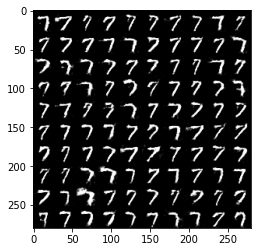

In [51]:
save_generated_image(image_grid, VAL, col, "images")
plt.imshow(image_grid, cmap="gray")

In [82]:
#пробуем генерировать картинки сами для одной категории
col = 1    # число картинок
VAL = 0    # заданная категория
y_tr =np.array([VAL]*col)   # размножаем список меток до нужной длины 
noise = generate_noise((col, NOISE_DIM))  # генерируем шумовые вектора по числу картинок 
y_tr = tf.keras.utils.to_categorical(y_tr, CAT_DIM) # преобразовали категории из списка в матрицу [0 1 0 ... 0]

print(y_tr/2)

col = 1    # число картинок
VAL = 8    # заданная категория
y_tr_1 =np.array([VAL]*col)   # размножаем список меток до нужной длины 
noise = generate_noise((col, NOISE_DIM))  # генерируем шумовые вектора по числу картинок 
y_tr_1 = tf.keras.utils.to_categorical(y_tr_1, CAT_DIM) # преобразовали категории из списка в матрицу [0 1 0 ... 0]
print(y_tr_1/2)

y_tr = y_tr+y_tr_1
print(y_tr/2)

generated_images = np.array(G.predict([noise, y_tr], verbose=0))  # создали картинки 
print(generated_images.shape)

[[0.5 0.  0.  0.  0.  0.  0.  0.  0.  0. ]]
[[0.  0.  0.  0.  0.  0.  0.  0.  0.5 0. ]]
[[0.5 0.  0.  0.  0.  0.  0.  0.  0.5 0. ]]
(1, 28, 28, 1)


In [83]:
image_grid = combine_images(generated_images)   # объединили все мелкие картики в одну 
print(image_grid.shape)
image_grid = image_grid[:, :, None]  # добавили размерность (для совместимости с цветными)
print(image_grid.shape)
image_grid = inverse_transform_images(image_grid)  # преобразовали пиксели в формат от 0 до 255

(28, 28)
(28, 28, 1)


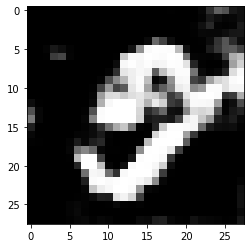

In [84]:
save_generated_image(image_grid, VAL, col, "images")
plt.imshow(image_grid, cmap="gray")

In [52]:
# генерируем все категории 
generated_images = []
ROW_LEN = 12 #10

for i in range(10):
    noise = generate_noise((ROW_LEN, NOISE_DIM))
    label_input = generate_condition_embedding(i, ROW_LEN)
    gen_images = G.predict([noise, label_input], verbose=0)
    generated_images.extend(gen_images)

generated_images = np.array(generated_images)
image_grid = combine_images(generated_images)
image_grid = inverse_transform_images(image_grid)


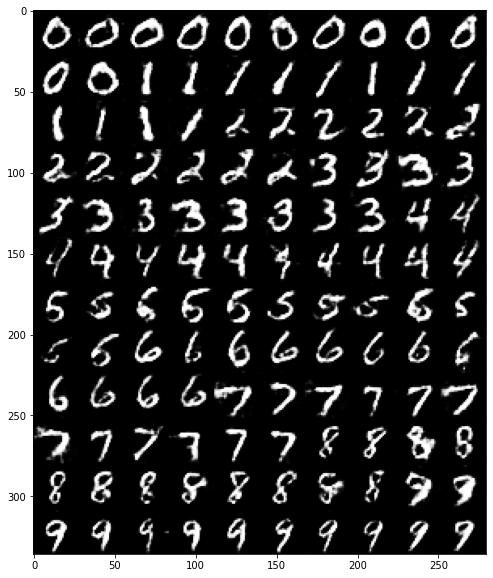

In [53]:
fig, ax = plt.subplots()
ax.imshow(image_grid, cmap="gray")
fig.set_figwidth(10)
fig.set_figheight(10)
plt.show()

In [36]:
folder_path = "images"
# сохраняем сгенерированные катринки
if not os.path.isdir(folder_path): # создаем недостоющие каталоги
    os.makedirs(folder_path)

file_path = "{0}/result_{1}_{2}.png".format(folder_path, VAL, col)
#cv2.imwrite(file_path, image.astype(np.uint8))
image_grid = image_grid[:, :, None]
img = tf.keras.preprocessing.image.array_to_img(image_grid.astype(np.uint8))
img.save(file_path)